Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

### Información sobre las variables del dataset
**Datos del cliente bancario**
* age
* job: tipo de trabajo
* marital: estado civil (nota: "divorced" implica tanto divorciado como viudo)
* education
* default: ¿no ha pagado alguna cuota de un crédito?
* balance: saldo medio anual, en euros
* housing: ¿tiene una hipoteca?
* loan: ¿tiene un crédito?

**Relacionado con el último contacto con el cliente en la campaña actual**
* contact: tipo de comunicación del último contacto
* day: día de la fecha de último contacto
* month: mes de la fecha de último contacto
* duration: duración del último contacto, en segundos

**Otros atributos**:
* campaign: número de contactos llevados a cabo durante esta campaña y para este cliente (incluye el último contacto)
pdays: número de dias que han pasado desde que el cliente fue contactado por última vez durante la pasada campaña (-1 significa que el cliente no fue contactado)
* previous: número de contactos que se han llevado a cabo antes de esta campaña y para este cliente
* poutcome: resultado de la última campaña de marketing

**Variable de salida (target)**:
* y: ¿tiene el cliente contratado un depósito a plazo fijo?

##Lectura de Datos

In [ ]:
df = spark.read.csv('dbfs:/FileStore/shared_uploads/layla.scheli@gmail.com/bank_full-1.csv',sep=';', header=True, inferSchema=True)

In [ ]:
#Comprobar lectura correcta del dataset
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

In [ ]:
#Comprobar dimensiones del dataset
print(len(df.columns))
print(df.count())

17
45211


In [ ]:
#Estudiar balanceo del dataset (sobre la variable target)

#El dataset cuenta con un 11,7% (5.289) de casos en los cuales el cliente tiene contratado un depósito a plazo fijo
from pyspark.sql import functions as F

df.groupBy('y').agg(F.count('y').alias('Cantidad'),F.round((F.count('y')/df.count())*100,2).alias('Share')).show()

+---+--------+-----+
|  y|Cantidad|Share|
+---+--------+-----+
| no|   39922| 88.3|
|yes|    5289| 11.7|
+---+--------+-----+



## Data Wrangling
Formateo de las variables (strings, numéricas y booleanas)
1) Notamos que los nombres de las columnas estan bajo buenas practicas, por lo que no hay que hacerles ninguna transformacion

2) Por otro lado, a partir de un PrintSchema() vemos que los formatos de las variables estan bien asignados.

3) Sin embargo, se ha notado la presencia de variables binarias, por lo que mas adelante se transformaran a 1s y 0s.

In [ ]:
df.show(3)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 3 rows



In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
#Hacemos un describe de las variables categoricas
import warnings
warnings.filterwarnings("ignore")

df.toPandas().describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [ ]:
#Ahora para las numericas
df.toPandas().describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


##Comprobación y eliminación de registros repetidos
No se encuentran registros repetidos teniendo en cuenta la totalidad de las columnas

Creemos que no es necesario eliminar duplicados de otra manera, ya que no hay ninguna variable id, y el resto no sería un problema que se repitan.

In [ ]:
df.count() - df.dropDuplicates().count()

Out[10]: 0

## Comprobación de columnas que no aportan información
Viendo las valores y conteos unicos para las variables categoricas, notamos lo siguiente:
La variable "default" cuenta con un desbalance demasiado grande como para que la misma aporte informacion a la base. Por lo tanto, esta columna deberia ser desestimada en caso de generar un modelo estadistico.

El resto de las variables no cuentan con un problema de concentracion de valores, por lo que estarian aportando informacion a la base.

In [ ]:
qualitative_vars = [c for c,t in df.dtypes if t in ['string']]

df_cat = df.select(qualitative_vars)

for col in df_cat.columns:
    df.groupBy(col).agg(F.count(col).alias('Cantidad'),F.round((F.count(col)/df.count())*100,2).alias('Share')).orderBy(F.col('Cantidad').desc()).show()

+-------------+--------+-----+
|          job|Cantidad|Share|
+-------------+--------+-----+
|  blue-collar|    9732|21.53|
|   management|    9458|20.92|
|   technician|    7597| 16.8|
|       admin.|    5171|11.44|
|     services|    4154| 9.19|
|      retired|    2264| 5.01|
|self-employed|    1579| 3.49|
| entrepreneur|    1487| 3.29|
|   unemployed|    1303| 2.88|
|    housemaid|    1240| 2.74|
|      student|     938| 2.07|
|      unknown|     288| 0.64|
+-------------+--------+-----+

+--------+--------+-----+
| marital|Cantidad|Share|
+--------+--------+-----+
| married|   27214|60.19|
|  single|   12790|28.29|
|divorced|    5207|11.52|
+--------+--------+-----+

+---------+--------+-----+
|education|Cantidad|Share|
+---------+--------+-----+
|secondary|   23202|51.32|
| tertiary|   13301|29.42|
|  primary|    6851|15.15|
|  unknown|    1857| 4.11|
+---------+--------+-----+

+-------+--------+-----+
|default|Cantidad|Share|
+-------+--------+-----+
|     no|   44396| 98.2|
|  

Para las variables numericas notamos que no hay ninguna columna que tenga valores repetidos en su totalidad, siendo el maximo un 81,7% en pdays y previous.

In [ ]:
numericas = [c for c,t in df.dtypes if t in ['int','float','double']]

df_num = df.select(numericas)

for col in df_num.columns:
    df.groupBy(col).agg(F.count(col).alias('Cantidad'),F.round((F.count(col)/df.count())*100,2).alias('Share')).orderBy(F.col('Cantidad').desc()).show(5)

+---+--------+-----+
|age|Cantidad|Share|
+---+--------+-----+
| 32|    2085| 4.61|
| 31|    1996| 4.41|
| 33|    1972| 4.36|
| 34|    1930| 4.27|
| 35|    1894| 4.19|
+---+--------+-----+
only showing top 5 rows

+-------+--------+-----+
|balance|Cantidad|Share|
+-------+--------+-----+
|      0|    3514| 7.77|
|      1|     195| 0.43|
|      2|     156| 0.35|
|      4|     139| 0.31|
|      3|     134|  0.3|
+-------+--------+-----+
only showing top 5 rows

+---+--------+-----+
|day|Cantidad|Share|
+---+--------+-----+
| 20|    2752| 6.09|
| 18|    2308|  5.1|
| 21|    2026| 4.48|
| 17|    1939| 4.29|
|  6|    1932| 4.27|
+---+--------+-----+
only showing top 5 rows

+--------+--------+-----+
|duration|Cantidad|Share|
+--------+--------+-----+
|     124|     188| 0.42|
|      90|     184| 0.41|
|      89|     177| 0.39|
|     122|     175| 0.39|
|     114|     175| 0.39|
+--------+--------+-----+
only showing top 5 rows

+--------+--------+-----+
|campaign|Cantidad|Share|
+--------+-

###Estudio de la varianza para las variables numéricas
Separo DF numerico:

In [ ]:
numericas = [c for c,t in df.dtypes if t in ['int','float','double']]

df_num = df.select(numericas)

**Calculo varianza y estadisticos basicos**

* Se agrego una medida de dispersion (coeficiente de variacion) para poder comparar la variancia, dividiendola sobre la media de cada columna particular.

* Notamos que la mayor dispersion se encuentra en las variables Previous (3,97) y pdays (2,49). Esto significa que hay mucha diferencia entre la cantidad de veces que los clientes han sido contactados en campañas previas, y por ende tambien en la cantidad de dias desde el ultimo contacto.

In [ ]:
avgs = [F.avg(col).alias('avg_' + col) for col in numericas]
maxs = [F.max(col).alias('max_' + col) for col in numericas]
mins = [F.min(col).alias('min_' + col) for col in numericas]
stds = [F.stddev(col).alias('std_' + col) for col in numericas]
var = [F.variance(col).alias('var_' + col) for col in numericas]
cv = [(F.stddev(col)/F.avg(col)).alias('cv_' + col) for col in numericas]

operations = avgs + stds + maxs + mins +var + cv

results = df.select(operations).first()

for col in numericas:
    avg  = results['avg_' + col]
    std  = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    vari = results['var_' + col]
    cvi= results['cv_'+ col]
    print('{}: avg={}, min={}, max={}, var={}, std={}, cv={}'.format(col, round(avg, 2), mini, maxi,round(vari, 2),round(std, 2),round(cvi,2)))

age: avg=40.94, min=18, max=95, var=112.76, std=10.62, cv=0.26
balance: avg=1362.27, min=-8019, max=102127, var=9270598.95, std=3044.77, cv=2.24
day: avg=15.81, min=1, max=31, var=69.26, std=8.32, cv=0.53
duration: avg=258.16, min=0, max=4918, var=66320.57, std=257.53, cv=1.0
campaign: avg=2.76, min=1, max=63, var=9.6, std=3.1, cv=1.12
pdays: avg=40.2, min=-1, max=871, var=10025.77, std=100.13, cv=2.49
previous: avg=0.58, min=0, max=275, var=5.31, std=2.3, cv=3.97


###Comprobación y eliminación de nulos

Al reemplazar los valores "unknown" como nulos, vemos que las variables poutcome, contact, education y job tienen valores nulos

In [ ]:
df = df.replace('unknown',None)

nulls = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / df.count(), 4).alias(c) for c in df.columns]

df.select(nulls).show()

+---+-----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|  job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|0.0|0.637|    0.0|   4.1074|    0.0|    0.0|    0.0| 0.0|28.7983|0.0|  0.0|     0.0|     0.0|  0.0|     0.0| 81.7478|0.0|
+---+-----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



Job, Education, Contact, serán reemplazados por la moda

In [ ]:
nulos_columnas = ['job','education','contact']

for col in nulos_columnas:

    moda = df.groupBy(F.col(col)).count().alias('count').orderBy(F.col('count').desc()).first()[0]

    df = df.fillna(moda,subset=[col])

Para la columna poutcome, los nulos son aquellos que no fueron contactados previamente. Es decir, con valor -1 en pdays.

Por este motivo, no seran reemplazados los nulos, sino que seran identificados como un 0, junto a las opciones origniales "other" y "failure". Aquellos que fueron casos contactados con exito ("success") seran codificados con un 1.

In [ ]:
#codifico valores y reemplazo por 1 y 0

df= df.withColumn('poutcome', F.when(F.col('poutcome') =='success', 1)\
                               .when(F.col('poutcome') =='other', 0)\
                                .when(F.col('poutcome') =='null', 0)\
                               .when(F.col('poutcome') =='failure', 0)\
                               .otherwise(F.col('poutcome')))

df= df.fillna('0',subset=['poutcome'])

df = df.withColumn('poutcome',F.col('poutcome').cast('int'))

df.groupBy('poutcome').count().show()

+--------+-----+
|poutcome|count|
+--------+-----+
|       1| 1511|
|       0|43700|
+--------+-----+



In [ ]:
nulls = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / df.count(), 4).alias(c) for c in df.columns]

df.select(nulls).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|0.0|0.0|    0.0|      0.0|    0.0|    0.0|    0.0| 0.0|    0.0|0.0|  0.0|     0.0|     0.0|  0.0|     0.0|     0.0|0.0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



### Comprobación y eliminación de outliers

Separamos las variables numericas y primero revisamos si son normales.

In [ ]:
# Importamos funcion para chequear normalidad

from scipy.stats import kstest
from scipy import stats

def is_normal(variable, alpha=0.05):

    # get std, mean
    mean = variable.mean()
    std = variable.std()
    # run kstest and get pvalue
    pvalue = kstest(variable, 'norm', args=(mean, std)).pvalue
    # check if pvalue is higher than alpha
    return pvalue >= alpha

In [ ]:
numericas = [c for c,t in df.dtypes if t in ['int','float','double']]

df_num = df.select(numericas)

for col in df_num.columns:
    check = df_num.toPandas()[col]
    print(col, is_normal(check,alpha=0.05))

age False
balance False
day False
duration False
campaign False
pdays False
previous False
poutcome False


Como ninguna lleva una distribucion normal, procedemos a realizar el test de Tuckey para outliers, pero con parametro = 3 en vez de 1.5, asi elimina los outliers extremos.

https://en.wikipedia.org/wiki/Tukey's_range_test

In [ ]:
def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """

    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1

    min_thresh = q1 - 3 * IQR
    max_thresh = q3 + 3 * IQR

    df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))

    return df_no_outliers

Las columnas con un numero considerable de outliers son balance, pdays y previous:

In [ ]:
for col in df_num.columns:

    nrows= df_num.count()
    outliers = remove_tukey_outliers(df_num,col)
    nrows_out= outliers.count()

    print('La columna ',col,' tiene ',nrows - nrows_out, '(', round((100 * (nrows - nrows_out) / nrows),2),'%)','outliers')

La columna  age  tiene  3 ( 0.01 %) outliers
La columna  balance  tiene  2562 ( 5.67 %) outliers
La columna  day  tiene  0 ( 0.0 %) outliers
La columna  duration  tiene  1233 ( 2.73 %) outliers
La columna  campaign  tiene  1462 ( 3.23 %) outliers
La columna  pdays  tiene  8257 ( 18.26 %) outliers
La columna  previous  tiene  8257 ( 18.26 %) outliers
La columna  poutcome  tiene  1511 ( 3.34 %) outliers


Sin embargo, no borraremos outliers de pdays y previous, ya que esto significaria una perdida de informacion relevante de la muestra, ya que estaria borrando todos los valores que no sean "-1" o 0, respectivamente.

Es decir, borraria a todos los registros que hayan sido contactados previamente.

In [ ]:
remove_tukey_outliers(df,'previous').groupBy('previous').agg(F.count(col).alias('Cantidad'),F.round((F.count('previous')/df.count())*100,2).alias('Share')).orderBy(F.col('Cantidad').desc()).show(5)
remove_tukey_outliers(df,'pdays').groupBy('pdays').agg(F.count(col).alias('Cantidad'),F.round((F.count('pdays')/df.count())*100,2).alias('Share')).orderBy(F.col('Cantidad').desc()).show(5)

+--------+--------+-----+
|previous|Cantidad|Share|
+--------+--------+-----+
|       0|   36954|81.74|
+--------+--------+-----+

+-----+--------+-----+
|pdays|Cantidad|Share|
+-----+--------+-----+
|   -1|   36954|81.74|
+-----+--------+-----+



Habiendo hecho este analisis, definimos como outliers a aquellos registros que sean extremos en las columnas Balance, Age, Duration o Campaign, eliminando 5123 registros.

In [ ]:
df_out=df

df_col_out = ['balance','age','duration','campaign']

for col in df_col_out:
    df_out = remove_tukey_outliers(df_out,col)

(df.count() - df_out.count()) # total borrados


Out[25]: 5095

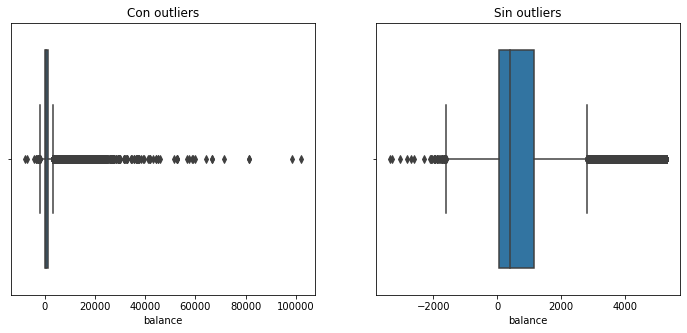

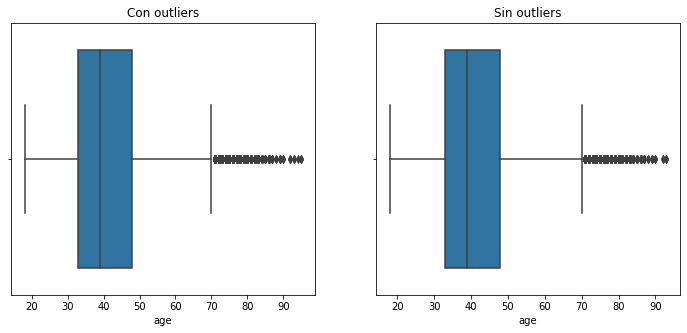

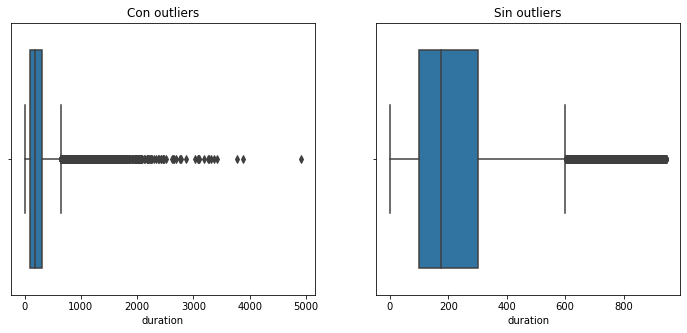

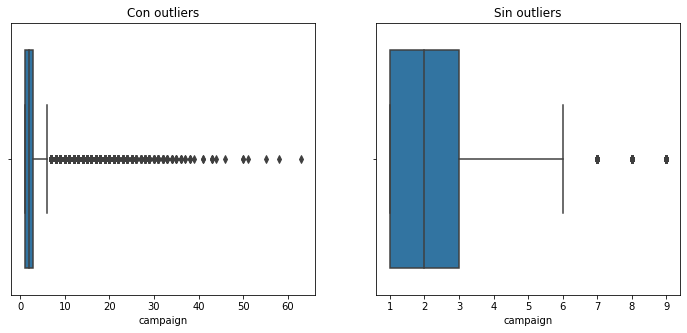

In [ ]:
#Enseñamos diferencia entre muestra con y sin outliers
import matplotlib.pyplot as plt
import seaborn as sns


df_boxplot= df.select(df_col_out)

def plot_outliers(column):
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)

    ax = sns.boxplot(x=df_boxplot.toPandas()[column]) #originales

    plt.title('Con outliers')

    temp = remove_tukey_outliers(df_boxplot,column) #sin outliers
    plt.subplot(1,2,2)
    ax2= sns.boxplot(x=temp.toPandas()[column])
    plt.title('Sin outliers')

for i in df_boxplot.columns:
    plot_outliers(i)

### Comprobar dimensiones y balanceo del dataset (tras terminar limpieza del dataset)
Se han eliminado 5.123 casos, siendo guardados bajo el nombrer df_out, quedando un total de 40.088 casos.

Esto genera que el dataset ahora haya perdido 1.150 casos de plazo fijo, pero la distribucion sigue siendo parecida a la original (10.3% vs 11.7%), como se nota debajo.

In [ ]:
df.groupBy('y').agg(F.count('y').alias('Cantidad'),F.round((F.count('y')/df.count())*100,2).alias('Share')).show()

+---+--------+-----+
|  y|Cantidad|Share|
+---+--------+-----+
| no|   39922| 88.3|
|yes|    5289| 11.7|
+---+--------+-----+



In [ ]:
df_out.groupBy('y').agg(F.count('y').alias('Cantidad'),F.round((F.count('y')/df_out.count())*100,2).alias('Share')).show()

+---+--------+-----+
|  y|Cantidad|Share|
+---+--------+-----+
| no|   35955|89.63|
|yes|    4161|10.37|
+---+--------+-----+



## Análisis Exploratorio de Datos
Estudio de las variables categóricas, aquellas variables binarias (loan, default, housing, contact e y), no seran consideradas como categoricas, sino como booleanas o numericas.

Así mismo, la variable Month sera pasada a Numerico.Por lo tanto, las variables categoricas serán Job, Marital y Education. Agrupamos columna Job en Trabaja y No Trabaja.

In [ ]:
df_out = df_out.withColumn('job_v2',F.when(F.col('job') =='retired', 'No trabaja')\
                               .when(F.col('job') =='student', 'No trabaja')\
                               .when(F.col('job') =='unemployed', 'No trabaja')\
                               .otherwise('Trabaja'))
df_out.groupBy('job_v2').count().show()

+----------+-----+
|    job_v2|count|
+----------+-----+
|No trabaja| 3987|
|   Trabaja|36129|
+----------+-----+



Estudiamos variables categoricas:

In [ ]:
df_out.toPandas().describe(include='O')

,job,marital,education,default,housing,loan,contact,month,y,job_v2
count,40116,40116,40116,40116,40116,40116,40116,40116,40116,40116
unique,11,3,3,2,2,2,2,12,2,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,no,Trabaja
freq,9010,24093,22538,39356,22573,33507,37631,12656,35955,36129


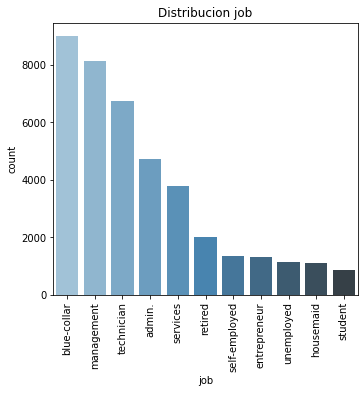

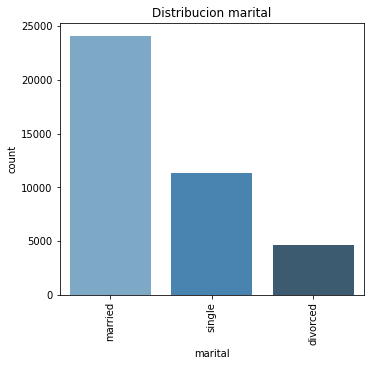

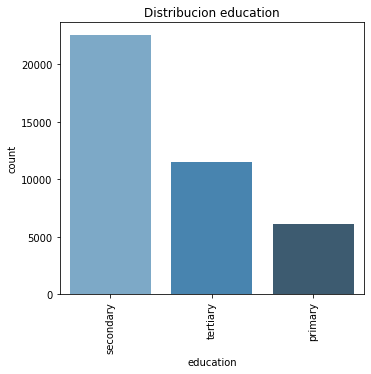

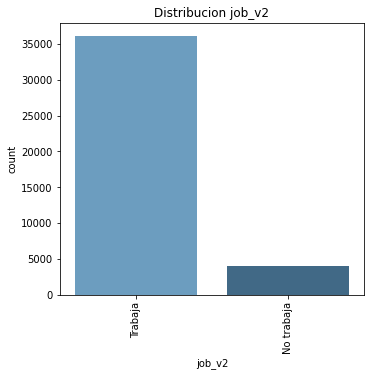

In [ ]:
def plot_cat(col):
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    plot = sns.countplot(x=df_out.toPandas()[col], palette='Blues_d',order = df_out.toPandas()[col].value_counts().index)

    plt.title('Distribucion ' + col)

    plt.xticks(rotation=90)

    return plot

cat_col=['job','marital','education','job_v2']

for col in cat_col :
    plot_cat(col)

Convertir variables categóricas a dummy:

In [ ]:
#importacion de las librerias
from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re

In [ ]:
#Confirmacion que no tenemos datos nulos para evitar errores
nulls = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / df_out.count(), 4).alias(c) for c in df_out.columns]

df_out.select(nulls).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_v2|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------+
|0.0|0.0|    0.0|      0.0|    0.0|    0.0|    0.0| 0.0|    0.0|0.0|  0.0|     0.0|     0.0|  0.0|     0.0|     0.0|0.0|   0.0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------+



In [ ]:
#Previo a convertir a dummies, convertimos Month a numerico:
df_out = df_out.withColumn('month',F.when(F.col('month') =='jan', 1)\
                               .when(F.col('month') =='feb', 2)\
                               .when(F.col('month') =='mar', 3)\
                               .when(F.col('month') =='apr', 4)\
                               .when(F.col('month') =='may', 5)\
                               .when(F.col('month') =='jun', 6)\
                               .when(F.col('month') =='jul', 7)\
                               .when(F.col('month') =='aug', 8)\
                               .when(F.col('month') =='sep', 9)\
                               .when(F.col('month') =='oct', 10)\
                               .when(F.col('month') =='nov', 11)\
                               .when(F.col('month') =='dec', 12)\
                               .otherwise('month'))

df_out=df_out.withColumn('month',F.col('month').cast('int'))

Para la conversion a dummies, se utilizaran tanto las funciones de Pandas como de Spark.

Se decidió esto ya que la ventaja de pandas es, ademas de ser una linea unica de codigo, la presencia de la opcion de eliminar el primer dato (drop_first), lo cual achica la dimension de la base final.

Conversion a dummies -> Pandas

In [ ]:
import pandas as pd

pandas_dummies = pd.get_dummies(data=df_out.toPandas(),drop_first=True)

In [ ]:
pandas_dummies.head()

,age,balance,day,month,duration,campaign,pdays,previous,poutcome,job_blue-collar,...,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,y_yes,job_v2_Trabaja
0,58,2143,5,5,261,1,-1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1,44,29,5,5,151,1,-1,0,0,0,...,0,1,1,0,0,1,0,0,0,1
2,33,2,5,5,76,1,-1,0,0,0,...,1,0,1,0,0,1,1,0,0,1
3,47,1506,5,5,92,1,-1,0,0,1,...,1,0,1,0,0,1,0,0,0,1
4,33,1,5,5,198,1,-1,0,0,1,...,0,1,1,0,0,0,0,0,0,1


In [ ]:
pd_dummies_spark = spark.createDataFrame(pandas_dummies) #dejamos el mismo df en spark para la matriz de correlacion mas adelante

Conversion a dummies -> Spark

Importo funcion para obtener dummies spark:

In [ ]:
def remove_nulls(df):
    df_no_nulls = df

    for element in df_no_nulls.columns:
        if df_no_nulls.where(df_no_nulls[element].isNull()).count() != 0:
            print('\tThe column "{}" has null values'.format(element))
            df_no_nulls = df_no_nulls.where(df_no_nulls[element].isNotNull())
        if df_no_nulls.where(df_no_nulls[element].isNull()).count() == 0:
            print('The column "{}" does not have null values'.format(element))

    return df_no_nulls

def check_nulls(df):

    existing_nulls = False

    for element in df.columns:
        if df.where(df[element].isNull()).count() != 0:
            print('\tThe column "{}" has null values'.format(element))
            existing_nulls = True
            break
        if df.where(df[element].isNull()).count() == 0:
            print('The column "{}" does not have null values'.format(element))

    return existing_nulls


def get_dummies_spark(df, dummy_cols):

    # check nulls

    existing_nulls = check_nulls(df)

    if existing_nulls == False:

        # StringIndexer + OneHotEncoder

        dictionaries = []

        for element in dummy_cols:
            print("StringIndexer + OneHotEncoder for column ", element)

            string_indexer = StringIndexer(inputCol=element, outputCol=element+'_category')
            onehotencoder = OneHotEncoder(dropLast=False, inputCol= string_indexer.getOutputCol(), outputCol=element+'_dummy')
            pipeline = Pipeline(stages=[string_indexer, onehotencoder])
            pipeline_model = pipeline.fit(df)
            dictionaries.append((element, list(enumerate(pipeline_model.stages[0].labels)), pipeline_model.stages[0]))
            df = pipeline_model.transform(df)
            df = df.drop(string_indexer.getOutputCol())

        # divide OneHotEncoder output in different columns

        for element in dictionaries:
            print("Divide OneHotEncoder output in several columns for original column ", element[0])

            df = (df.withColumn('activated_indices'+element[0], F.udf(lambda x: x.toArray().tolist(), ArrayType(DoubleType()))
                                (F.col(element[0]+'_dummy'))))

            vocab = [re.sub(r'\W', '_', value) for value in element[-1].labels]
            df = df.select(df.columns + [F.col("activated_indices"+element[0])[i] for i in range(len(vocab))])

            dictionary = {"activated_indices"+element[0]+"[{0}]".format(x): element[0]+'_'+vocab[x] for x in range(len(vocab))}

            # rename columns
            df = df.selectExpr(["{0} as {1}".format(x, x) if x not in dictionary else "{0} as {1}".format(x, dictionary[x])
                                          for x in df.columns])
            df = df.drop('activated_indices'+element[0], element[0]+'_dummy')

    else:
        print("There are nulls in your dataframe, please remove them or fill them before creating dummy features")


    return df

In [ ]:
#Creamos df final con dummies spark
dummy_cols = [c for c,t in df_out.dtypes if t in ['string']]
df_no_nulls = remove_nulls(df_out)
df_no_nulls_dummies = get_dummies_spark(df_no_nulls, dummy_cols)
df_no_nulls_dummies.limit(10).toPandas()

The column "age" does not have null values
The column "job" does not have null values
The column "marital" does not have null values
The column "education" does not have null values
The column "default" does not have null values
The column "balance" does not have null values
The column "housing" does not have null values
The column "loan" does not have null values
The column "contact" does not have null values
The column "day" does not have null values
The column "month" does not have null values
The column "duration" does not have null values
The column "campaign" does not have null values
The column "pdays" does not have null values
The column "previous" does not have null values
The column "poutcome" does not have null values
The column "y" does not have null values
The column "job_v2" does not have null values
The column "age" does not have null values
The column "job" does not have null values
The column "marital" does not have null values
The column "education" does not have null

,age,job,marital,education,default,balance,housing,loan,contact,day,...,housing_yes,housing_no,loan_no,loan_yes,contact_cellular,contact_telephone,y_no,y_yes,job_v2_Trabaja,job_v2_No_trabaja
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,35,management,married,tertiary,no,231,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,28,management,single,tertiary,no,447,yes,yes,cellular,5,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,58,retired,married,primary,no,121,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9,43,technician,single,secondary,no,593,yes,no,cellular,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Crear variables derivadas en caso que nos parezca interesante incluir alguna
Sumado a la creacion previa de Job_v2, se puede agrupar la edad segun la generacion en la que caiga:

In [ ]:
df_no_nulls_dummies = df_no_nulls_dummies.withColumn('range_age',F.when(F.col('age') < 18,'[18 <]')\
                                    .when(F.col('age').between(19,30),'[19-30]')\
                                    .when(F.col('age').between(31,45),'[31-45]')\
                                    .when(F.col('age').between(46,60),'[46-60]')\
                                    .otherwise('[60 >]'))

In [ ]:
df_no_nulls_dummies.limit(10).toPandas()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,housing_no,loan_no,loan_yes,contact_cellular,contact_telephone,y_no,y_yes,job_v2_Trabaja,job_v2_No_trabaja,range_age
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[46-60]
1,44,technician,single,secondary,no,29,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[46-60]
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]
5,35,management,married,tertiary,no,231,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]
6,28,management,single,tertiary,no,447,yes,yes,cellular,5,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,[19-30]
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]
8,58,retired,married,primary,no,121,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,[46-60]
9,43,technician,single,secondary,no,593,yes,no,cellular,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,[31-45]


**Cálculo de la matriz de correlación**

Out[46]: <AxesSubplot:>

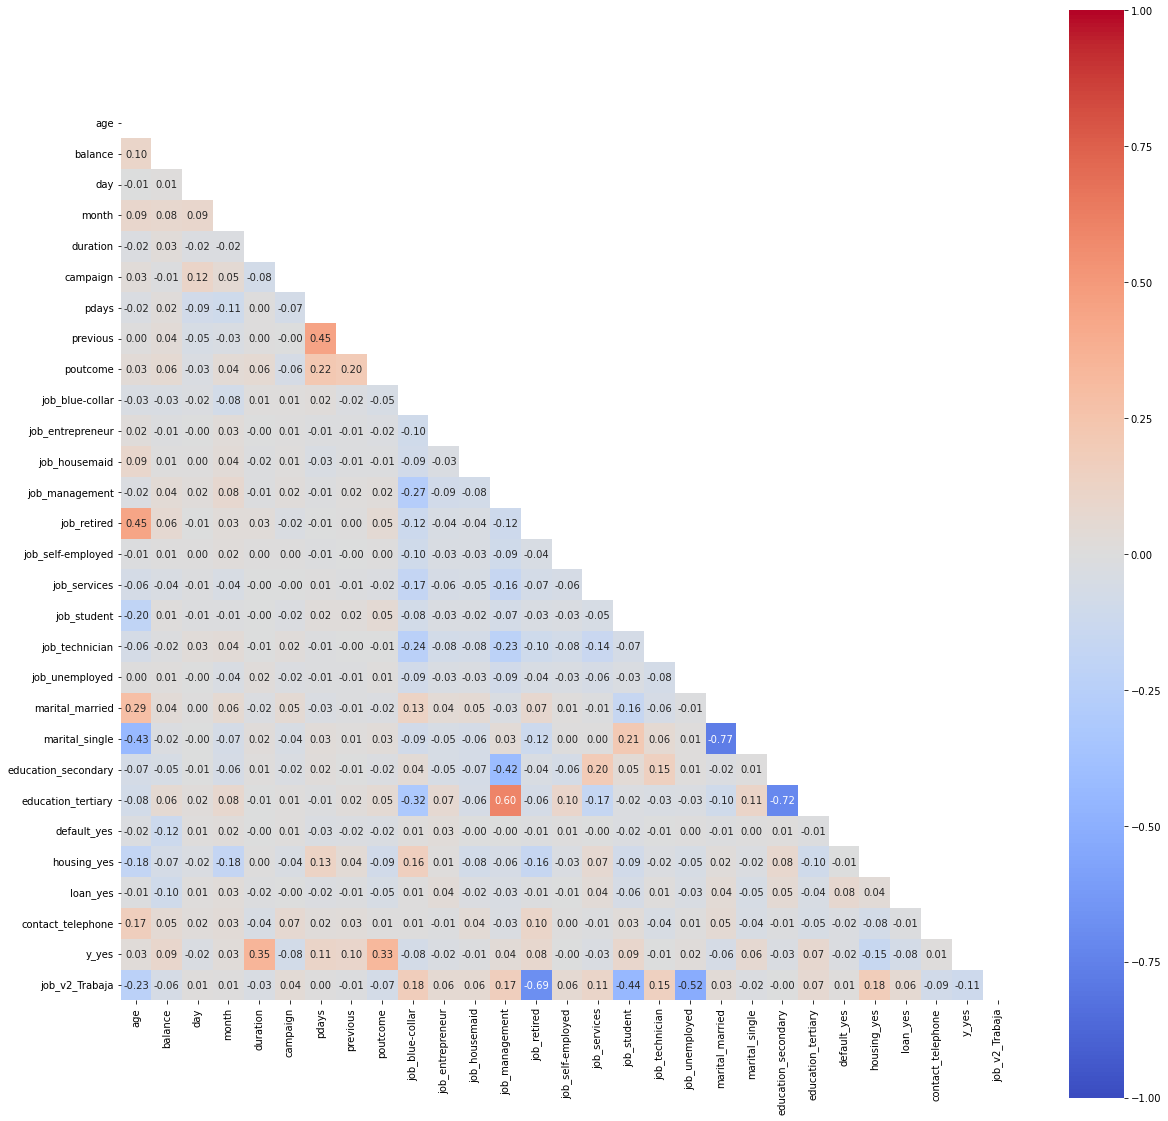

In [ ]:
numericas = [c for c,t in pd_dummies_spark.dtypes if t in ['bigint','float','double']]

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_matrix = Statistics.corr(pd_dummies_spark.select(numericas).rdd.map(lambda v: Vectors.dense(v)),
                              method='pearson')


corr_matrix = pd.DataFrame(corr_matrix, columns=numericas, index=numericas)


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

corr_matrix = corr_matrix.mask(mask)
corr_matrix

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

In [ ]:
#Comprobar si hay variables correlacionadas
numericas = [c for c,t in pd_dummies_spark.dtypes if t in ['bigint','float','double']]

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_matrix = Statistics.corr(pd_dummies_spark.select(numericas).rdd.map(lambda v: Vectors.dense(v)),
                              method='pearson')


corr_matrix = pd.DataFrame(corr_matrix, columns=numericas, index=numericas)

In [ ]:
# Imported functions
def corrank(X):
    import itertools
    df_correlaciones = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])
    return df_correlaciones.sort_values(by='corr',ascending=False)

La variable Job_management y Educacion terciaria estan altamente correlacionados, como tambien lo esta la cantidad de dias que pasaron desde el ultimo contacto y el resultado de este mismo. Esta ultima se debe a la existencia de la una mayoria que no fue contactada y por ende no tiene resultado alguno.

In [ ]:
corrank(corr_matrix).head(10)

,pairs,corr
279,"(job_management, education_tertiary)",0.859330
153,"(pdays, previous)",0.735737
12,"(age, job_retired)",0.697822
214,"(poutcome, y_yes)",0.575732
18,"(age, marital_married)",0.573711
128,"(duration, y_yes)",0.562109
331,"(job_student, marital_single)",0.416574
320,"(job_services, education_secondary)",0.401047
154,"(pdays, poutcome)",0.399326
399,"(housing_yes, job_v2_Trabaja)",0.377736


In [ ]:
#Al transformar a dummies las variables categoricas, notamos que como son opciones excluyentes, tiene una alta correlacion negativa.
corrank(corr_matrix).tail(10)

,pairs,corr
27,"(age, job_v2_Trabaja)",-0.388970
101,"(month, housing_yes)",-0.389887
228,"(job_blue-collar, education_tertiary)",-0.483057
339,"(job_student, job_v2_Trabaja)",-0.524839
360,"(job_unemployed, job_v2_Trabaja)",-0.635400
19,"(age, marital_single)",-0.676899
278,"(job_management, education_secondary)",-0.752187
300,"(job_retired, job_v2_Trabaja)",-0.794772
378,"(education_secondary, education_tertiary)",-0.908154
361,"(marital_married, marital_single)",-0.965039


###Modelos de predicción

In [ ]:
#Confirmo que no hayan variables string
pandas_dummies.dtypes

Out[51]: age                    int32
balance                int32
day                    int32
month                  int32
duration               int32
campaign               int32
pdays                  int32
previous               int32
poutcome               int32
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
marital_married        uint8
marital_single         uint8
education_secondary    uint8
education_tertiary     uint8
default_yes            uint8
housing_yes            uint8
loan_yes               uint8
contact_telephone      uint8
y_yes                  uint8
job_v2_Trabaja         uint8
dtype: object

In [ ]:
#Separo en train y testing
X = pandas_dummies.drop(columns = 'y_yes')
y = pandas_dummies['y_yes']

In [ ]:
!pip install xgboost

     |▋                               | 3.6 MB 7.1 MB

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 200.3 MB 8.8 kB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-a9535379-9e21-4630-9d01-2abb6141fa3e/bin/python -m pip install --upgrade pip' command.


In [ ]:
import sklearn as sk
from sklearn import model_selection, ensemble, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import tree

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 10.18
% Positive class in Test  = 11.14


Probando 4 modelos predictivos, notamos que XGBoost classifier es el que tiene mayor exito de prediccion, otorgando un area debajo de la curva de 0.71, lo cual no es mucho.

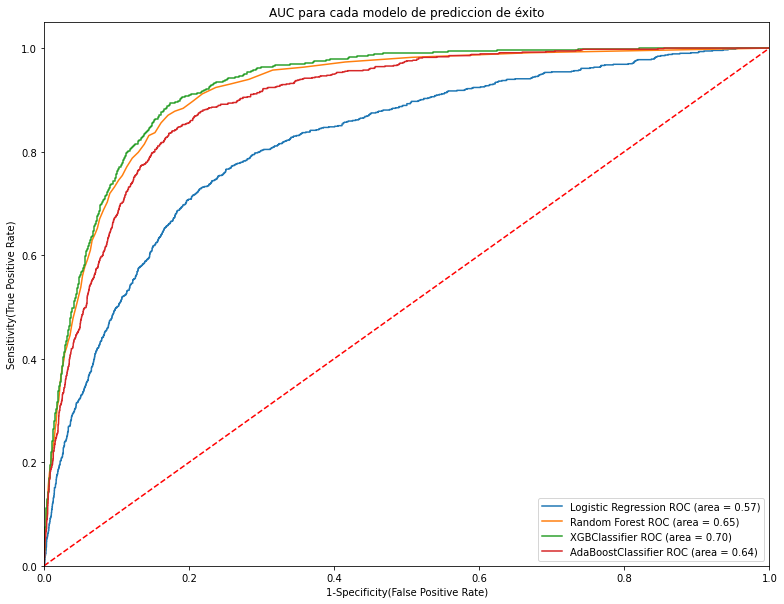

In [ ]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},{
    'label': 'XGBClassifier',
    'model': XGBClassifier()
},{
    'label': 'AdaBoostClassifier',
    'model': AdaBoostClassifier()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('AUC para cada modelo de prediccion de éxito')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(13, 10)
plt.show()   # Display

Vemos la importancia de las variables en el modelo:

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)

Out[59]: RandomForestClassifier(n_estimators=1000)

In [ ]:
import numpy as np

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

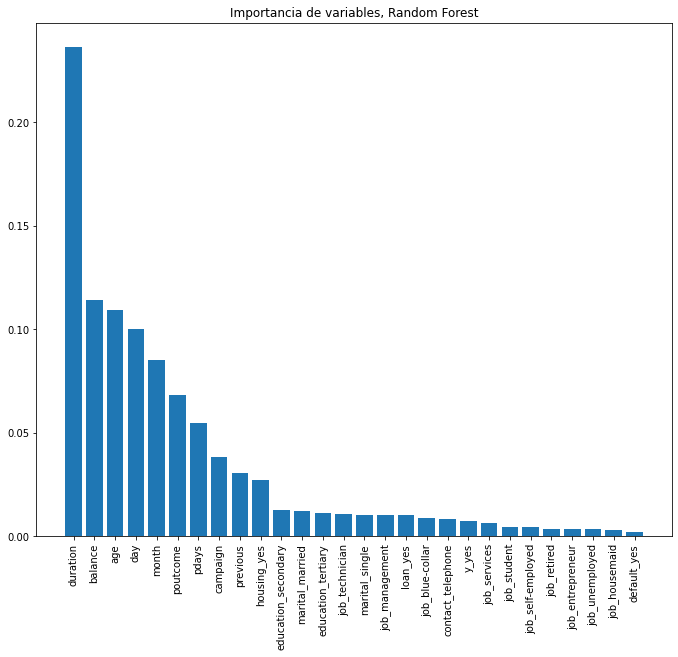

In [ ]:
#Mayor importancia: Duration, Balance, Age
import matplotlib.pyplot as plt

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(pandas_dummies.shape[1]-1), pandas_dummies.columns[sorted_indices], rotation=90)
plt.tight_layout()

from matplotlib.pyplot import figure

fig = plt.gcf()
fig.set_size_inches(10, 15)
plt.title('Importancia de variables, Random Forest')
plt.show()